### Predictor Features
- fl_date
- mkt_unique_carrier
- branded_code_share
- mkt_carrier
- mkt_carrier_fl_num
- op_unique_carrier
- tail_num
- op_carrier_fl_num
- origin_airport_id
- origin
- origin_city_name
- dest_airport_id
- dest
- dest_city_name
- crs_dep_time
- crs_arr_time
- dup
- crs_elapsed_time
- flights
- distance

### Target Variable
- arr_delay

# **Machine Learning**

In this file, instructions how to approach the challenge can be found.
- **Regression Problem**: The goal is to predict delay of flights.
- **(Stretch) Multiclass Classification**: If the plane was delayed, we will predict what type of delay it is (will be).
- **(Stretch) Binary Classification**: The goal is to predict if the flight will be cancelled.

The target variable is **ARR_DELAY**. We need to be careful which columns to use and which don't. For example, DEP_DELAY is going to be the perfect predictor, but we can't use it because in real-life scenario, we want to predict the delay before the flight takes of --> We can use average delay from earlier days but not the one from the actual flight we predict.  

For example, variables **CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY** shouldn't be used directly as predictors as well. However, we can create various transformations from earlier values.

We will be evaluating your models by predicting the ARR_DELAY for all flights **1 week in advance**.

In [746]:
current_path = os.getcwd()

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn import metrics
from sklearn.metrics import recall_score, precision_score, r2_score
import xgboost as xgb
from xgboost import XGBRegressor
import pickle
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder, PolynomialFeatures, MinMaxScaler, OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import Ridge
import warnings
import os
from datetime import datetime
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
warnings.filterwarnings("ignore")


In [413]:
df = pd.read_csv('/Users/arjunduggal/Desktop/lighthouse-data-notes/Midterm_1/Data/FLIGHTS_cleaned.csv')
df_passengers = pd.read_csv('/Users/arjunduggal/Desktop/lighthouse-data-notes/Midterm_1/Data/PASSENGER_cleaned.csv')

In [414]:
model_df = df[['arr_delay','dep_delay','fl_date','op_unique_carrier','origin','dest',
               'crs_dep_time','crs_arr_time','mkt_carrier','flights','crs_elapsed_time','distance','origin_city_name',
               'dest_city_name','origin_airport_id','dest_airport_id']]

In [415]:
additional_info_df = df_passengers[['departures_performed','seats','passengers','carrier','month']].groupby(['carrier','month']).mean().reset_index()

# **Feature Engineering**

Feature engineering will play a crucial role in this problems. We have only very little attributes so we need to create some features that will have some predictive power.

- weather: we can use some weather API to look for the weather in time of the scheduled departure and scheduled arrival.
- statistics (avg, mean, median, std, min, max...): we can take a look at previous delays and compute descriptive statistics
- airports encoding: we need to think about what to do with the airports and other categorical variables
- time of the day: the delay probably depends on the airport traffic which varies during the day.
- airport traffic
- unsupervised learning as feature engineering?
- **what are the additional options?**: Think about what we could do more to improve the model.

## **Replacing any potential null elapsed time values with place holder of 0 (reduces chance of any bias influecing a key feature in our model)**


In [416]:
model_df['crs_elapsed_time'] = model_df['crs_elapsed_time'].fillna(0)
df['arr_delay'] = df['arr_delay'].fillna(0)

## **Simply check whether there is a arrival delay or not through a binary value**


In [417]:
if 'arr_delay' in model_df.columns:
    model_df['delay_occured'] = model_df['arr_delay'].map(lambda x: 0 if x <= 0 else 1)
#     model_df.drop(columns='arr_delay', inplace=True)

## **Converting datetime feature from yy-mm-dd in order to grab the specific month, day of the week. Strong relationship between what day of the week it is and how much air traffic ensues**


In [418]:
month_to_season = {1: 1, 2: 1, 3: 2, 4: 2, 5: 2, 6: 3, 7: 3, 8: 3, 9: 4, 10: 4, 11: 4, 12: 1}
model_df['fl_date'] = pd.to_datetime(model_df['fl_date'], errors='coerce')
model_df['month'] = model_df['fl_date'].dt.month
model_df['day_of_week'] = model_df['fl_date'].dt.dayofweek
model_df['day_of_month'] = model_df['fl_date'].dt.day
model_df['year'] = model_df['fl_date'].dt.year
model_df['season'] = model_df['month'].map(month_to_season)
#model_df.drop(columns=['fl_date'],inplace=True)

## **Categorzining the kind of flight that endured based on the crs_elapsed_time feature, doing so as we believe longer flights tend to generate a greater arrival delay then others**

In [419]:
#encoding function to numerical describe the duration of a flight based on three intervals (less than 3 hours, in between 3-6 hours and greater then 6 hours)
def time_cat(df, col):
    '''Determine if flight length is SHORT (0), MEDIUM(1) or LONG(2) based on expected elapsed flight time. '''
    length=[]
    for i in df[col]:
        if i < (3*60): # up to 3 hours
            length.append(0) # 0 = SHORT 
        elif (i >= (3*60)) and (i < (6*60)): # 3-6 hours
            length.append(1) # 1 = MEDIUM 
        elif i >= (6*60):# 6+ hours
            length.append(2) # 2 = LONG 

    df['time_cat'] = length

In [420]:
time_cat(model_df,'crs_elapsed_time')

In [421]:
model_df.time_cat.value_counts()

0    156229
1     37436
2      2890
Name: time_cat, dtype: int64

## **Number of passengers on average per depature**

In [422]:
model_df = pd.merge(model_df,additional_info_df, how = 'left', left_on=['mkt_carrier','month'], right_on=['carrier','month']).drop(columns='carrier')
model_df['pass_per_dep'] = model_df['passengers']/model_df['departures_performed']
model_df['seats_filled'] = model_df['passengers']/model_df['seats']

## **Distance/ crs_elapsed_time, unsure if we'll be privied to this sort of information?**

In [423]:
def avg_plane_velo(df,distance,time):
    '''Creating a basic function derived from kinematics that takes in airtime (minutes) and distance(miles) 
    to return the average plane velocity, want the si unit to be in Mph'''
    
    df['avg_plane_velocity'] = df[distance] / df[time] * 60 

In [424]:
avg_plane_velo(model_df,'distance','crs_elapsed_time')

## **Converting to Milatary time, longer process is to create categorical time of day information using time_day function defined below as well as expected delays relating to the time of day departure**

In [425]:
def time_row(row):
    row_int = int(row)
    row_str = str(row_int)
    len_row = len(row_str)
    if len_row ==1:
        minute = "00"
        hour = row_str
        row = hour+minute
    if len_row ==2:
        minute = '0' +row_str[1]
        hour = row_str[0]
        row = hour + minute
    elif len_row ==4:
        minute = row_str[2] +row_str[3]
        hour = row_str[0] + row_str[1]
        row = hour + minute
        if row =='24:00':
            row ='23:59'
    return str(row)

In [426]:
model_df['dep_time_milatary'] = model_df['crs_dep_time'].apply(time_row)

In [427]:
model_df['arr_time_milatary'] = model_df['crs_arr_time'].apply(time_row)

## **Time Arrival and Departure function (encoding method)**


In [428]:
def time_day(df,col,new_col):
    lst=[]
    for i in df[col]:
        if ((len(i)==4) and (int(i[:2]) >=23)) or ((len(i)==3) and (int(i[0]) < 5)):
            lst.append(0) # 0 = OVERNIGHT
        elif ((len(i) == 3) and (int(i[0])>=5)) or ((len(i)==4) and (int(i[:2]) < 12)):
            lst.append(1) # 1 = MORNING
        elif (len(i)==4) and (int(i[:2]) >= 12) and (int(i[:2]) < 18):
            lst.append(2) # 2 = AFTERNOON
        elif (len(i)==4) and (int(i[:2])>=18) and (int(i[:2])<23):
            lst.append(3) # 3 = EVENING
    
    print(len(lst))
    df[[new_col]] = lst
    
    return df[[new_col]]

In [429]:
time_day(model_df,'dep_time_milatary','dep_time_haul')

196555


,dep_time_haul
0,2
1,1
2,2
3,2
4,1
...,...
196550,1
196551,1
196552,1
196553,3


In [430]:
time_day(model_df,'arr_time_milatary','arr_time_haul')

196555


,arr_time_haul
0,3
1,3
2,0
3,3
4,1
...,...
196550,2
196551,1
196552,1
196553,3


## **Origin and Arrival state Columms**

In [431]:
model_df['origin_state'] = model_df['origin_city_name'].str[-2:]

In [432]:
model_df['dest_state']= model_df['dest_city_name'].str[-2:]

## **Summary statistics for aiports based on arrival and depature locations**

In [433]:
model_df['origin_airport_volume'] = model_df.groupby(['origin_airport_id'])['flights'].transform(np.sum) 

In [434]:
model_df['dest_aiport_volume'] =model_df.groupby(['dest_airport_id'])['flights'].transform(np.sum)

In [435]:
model_df['carrier_origin_apt_vol'] = model_df.groupby(['origin_airport_id','op_unique_carrier'])['flights'].transform(np.sum)
model_df['carrier_dest_apt_vol'] = model_df.groupby(['dest_airport_id','op_unique_carrier'])['flights'].transform(np.sum)

In [436]:
model_df['carrier_origin_apt_pct'] = model_df['carrier_origin_apt_vol'] / model_df['origin_airport_volume'] * 100
model_df['carrier_dest_apt_pct'] = model_df['carrier_dest_apt_vol'] / model_df['dest_aiport_volume'] * 100

In [437]:
model_df['mean_carrier_arr_delay'] = model_df.groupby(['op_unique_carrier','month'])['arr_delay'].transform(np.mean)
model_df['mean_carrier_dep_delay'] = model_df.groupby(['op_unique_carrier','month'])['dep_delay'].transform(np.mean)

## **Changing to category dtype to use a nice encoding process that won't increase the dimensionality of our Df (unsure if we can then use a standard scaler effectively use this encoding method)**


In [438]:
for i in ['op_unique_carrier','origin','dest','origin_state','dest_state']:
    model_df[[i]] = model_df[[i]].astype('category')

    


In [439]:
model_df['op_unique_carrier'] = model_df.op_unique_carrier.cat.codes
model_df['origin'] = model_df.origin.cat.codes
model_df['dest'] = model_df.dest.cat.codes
model_df['origin_state'] = model_df.origin_state.cat.codes
model_df['dest_state'] = model_df.dest_state.cat.codes

In [440]:
temp = model_df.copy()

## **Final Examination Of Data Prior to Modelling**

In [441]:
model_df.drop(columns=['crs_dep_time','crs_arr_time','origin_city_name','dest_city_name','dep_time_milatary','arr_time_milatary'
                       ,'fl_date','mkt_carrier','seats',
                      'arr_delay','dep_delay',
                       'departures_performed','seats','passengers','crs_elapsed_time','origin_airport_id','dest_airport_id','delay_occured'],inplace=True,axis=1)

In [442]:
model_df.columns

Index(['op_unique_carrier', 'origin', 'dest', 'flights', 'distance', 'month',
       'day_of_week', 'day_of_month', 'year', 'season', 'time_cat',
       'pass_per_dep', 'seats_filled', 'avg_plane_velocity', 'dep_time_haul',
       'arr_time_haul', 'origin_state', 'dest_state', 'origin_airport_volume',
       'dest_aiport_volume', 'carrier_origin_apt_vol', 'carrier_dest_apt_vol',
       'carrier_origin_apt_pct', 'carrier_dest_apt_pct',
       'mean_carrier_arr_delay', 'mean_carrier_dep_delay'],
      dtype='object')

In [443]:
print(df[['arr_delay']].isnull().any())
total = model_df.isnull().sum().sort_values(ascending=False)
percent = (model_df.isnull().sum()/model_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['total', 'percent'])
missing_data

arr_delay    False
dtype: bool


,total,percent
mean_carrier_dep_delay,0,0.0
mean_carrier_arr_delay,0,0.0
origin,0,0.0
dest,0,0.0
flights,0,0.0
distance,0,0.0
month,0,0.0
day_of_week,0,0.0
day_of_month,0,0.0
year,0,0.0


## **Removal of features with small variance understanding that transforming an array back to a data-frame preserves column labels**

In [475]:
from sklearn.feature_selection import VarianceThreshold
vt = VarianceThreshold(0.1)
df_transformed = vt.fit_transform(model_df)
selected_columns = model_df.columns[vt.get_support()]
df_transformed = pd.DataFrame(df_transformed, columns = selected_columns)

In [476]:
y = df[['arr_delay']]
df_corr = df_transformed.corr().abs()
indices = np.where(df_corr > 0.9)
indices = [(df_corr.index[x], df_corr.columns[y]) for x, y in zip(*indices)
              if x != y and x < y]
for idx in indices:
    try:
        df_transformed.drop(idx[1], axis = 1, inplace=True)
    except KeyError:
        pass

In [477]:
from sklearn.feature_selection import f_regression, SelectKBest #stack overflow 
skb = SelectKBest(f_regression, k=15)
X = skb.fit_transform(df_transformed, y)
X = pd.DataFrame(X,columns=df_transformed.columns[skb.get_support()])
X

,distance,season,time_cat,pass_per_dep,avg_plane_velocity,dep_time_haul,arr_time_haul,dest_state,origin_airport_volume,dest_aiport_volume,carrier_origin_apt_vol,carrier_dest_apt_vol,carrier_origin_apt_pct,carrier_dest_apt_pct,mean_carrier_arr_delay
0,1017.0,2.0,0.0,137.120517,415.102041,2.0,3.0,8.0,7097.0,873.0,3647.0,111.0,51.387910,12.714777,3.774210
1,2077.0,3.0,1.0,140.883487,426.780822,1.0,3.0,26.0,2412.0,6209.0,225.0,2472.0,9.328358,39.813174,12.272488
2,1491.0,4.0,1.0,142.235989,442.871287,2.0,0.0,19.0,6797.0,2602.0,1611.0,94.0,23.701633,3.612606,2.155639
3,407.0,4.0,0.0,117.019843,271.333333,2.0,3.0,4.0,4142.0,1337.0,1809.0,1036.0,43.674553,77.486911,-1.644198
4,109.0,4.0,0.0,143.766544,118.909091,1.0,1.0,4.0,6162.0,2435.0,817.0,220.0,13.258682,9.034908,2.425584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196550,1476.0,3.0,1.0,123.820258,421.714286,1.0,2.0,44.0,1639.0,1618.0,821.0,606.0,50.091519,37.453646,6.291638
196551,482.0,2.0,0.0,141.505765,324.943820,1.0,1.0,40.0,194.0,394.0,194.0,7.0,100.000000,1.776650,5.829493
196552,141.0,2.0,0.0,143.017015,126.268657,1.0,1.0,5.0,35.0,6825.0,10.0,553.0,28.571429,8.102564,9.159722
196553,1726.0,4.0,1.0,143.766544,390.792453,3.0,3.0,4.0,9654.0,1100.0,1931.0,148.0,20.002072,13.454545,4.774797


In [361]:
# #make a heatmap here
# plt.figsize(1
# sns.heatmap(X.corr(), annot=True)


## **Scaling Process (standard scaler), sidenote should we scale the target or no?**

In [362]:
# from sklearn import preprocessing
# ss = preprocessing.StandardScaler()
# df_train_scaled = pd.DataFrame(ss.fit_transform(X),columns = X.columns)
# df_target_scaled = pd.DataFrame(ss.fit_transform(df[['arr_delay']])) to understand the variance of the data better
# X = df_train_scaled 
# y = df_target_scaled 

## **Regular Components train and test Sets**

In [488]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8, random_state=123)

## **PCA / Dimensionality Redction Process**

In [489]:
from sklearn.decomposition import PCA

pca = PCA(random_state = 22)
pca.fit_transform(X)
eigenvalues = pca.explained_variance_
a=0
for num in eigenvalues: #definition of what a principal component is
    if num > 1:
        a += 1


pca = PCA(n_components = a, random_state = 42)
X_pca = pca.fit_transform(X)
X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(X_pca, y, test_size=0.2, random_state=8732)
X_train_samp = pd.DataFrame(X_train).sample(frac = 0.1).values
y_train_samp = pd.DataFrame(y_train).sample(frac = 0.1).values

In [490]:
#pca may not be optimal in this case

# pca_X_train = pd.DataFrame(pca.fit_transform(X_train))
# pca_X_test = pd.DataFrame(pca.fit_transform(X_test))

# plt.plot(np.cumsum(np.round(pca.explained_variance_ratio_,decimals =3)*100))
# plt.title('PCA for model_df')
# plt.show()

## **Modeling**

Use different ML techniques to predict each problem.

- linear / logistic / multinomial logistic regression
- Naive Bayes
- Random Forest
- SVM
- XGBoost
- The ensemble of your own choice

## **Linear Regression**

In [491]:
#creating and fitting the linear regression model with our test and trained data
lr_model = LinearRegression()
lr_model.fit(X_train,y_train)
lin_pred = lr_model.predict(X_test)

In [492]:
#Applying resampling process (cross validation) to reaffirm our results, not just from one subsection of the data
kfold = KFold(n_splits=10, random_state=7, shuffle=True)
scoring = 'r2'
results = cross_val_score(lr_model, X_train, y_train, cv=kfold, scoring=scoring)
print("R^2: %.3f (%.3f)" % (results.mean(), results.std()))

R^2: 0.021 (0.002)


### *Linear Regression Metrics*

In [493]:
print("Our Linear regression model mean squared error value (unnormalized): {}".format(metrics.mean_squared_error(y_test,lin_pred)))
print("Our Linear regression r^2 value: {}".format(metrics.r2_score(y_test,lin_pred))) #? pca significantly reduced this lol

Our Linear regression model mean squared error value (unnormalized): 2216.050038827574
Our Linear regression r^2 value: 0.02163006245926824


### *Summary of Findings for Linear Regression Model and Hyper Tuning* 

In [494]:
# Linear Regression on Original Features
#Even for a simple regression model were hoping to determine optimal parameters to fit our training data set even better/ make better future predictions
lin_params = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid_lin = GridSearchCV(LinearRegression(), lin_params, cv=5, verbose=1, n_jobs=-1)
grid_lin.fit(X_train, y_train)


Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=LinearRegression(), n_jobs=-1,
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'normalize': [True, False]},
             verbose=1)

In [495]:
linreg = grid_lin.best_estimator_
linreg_score = cross_val_score(linreg, X_train, y_train, cv=5)
y_linreg = linreg.predict(X_test)
########################################################################################################
df_lr = pd.DataFrame({'Predicted':lin_pred[:,0],'Actual':np.array(y_test.iloc[:,0])})
df_lr['residuals'] = df_lr['Actual']-df_lr['Predicted']
########################################################################################################
print("The variance between the actual arrival delays is {} minutes".format(df_lr.loc[:,"Actual"].var()))
print("The mean residual is: {}".format(np.mean(df_lr)[2]))
print('Cross Validation Score: ', round(linreg_score.mean() * 100, 2).astype(str) + '%')
print('R2 Score \t{:.2f}'.format(metrics.r2_score(y_test, y_linreg)))
print('Test RMSE \t{:.2f}'.format(metrics.mean_squared_error(y_test, y_linreg)))
########################################################################################################
df_lr

The variance between the actual arrival delays is 2265.100681748665 minutes
The mean residual is: -0.7142347601030572
Cross Validation Score:  2.06%
R2 Score 	0.02
Test RMSE 	2216.05


,Predicted,Actual,residuals
0,6.619254,-18.0,-24.619254
1,11.123145,57.0,45.876855
2,4.458734,15.0,10.541266
3,6.805501,20.0,13.194499
4,-0.389066,-8.0,-7.610934
...,...,...,...
39306,8.436177,10.0,1.563823
39307,-3.967387,-17.0,-13.032613
39308,4.100933,-21.0,-25.100933
39309,9.730699,39.0,29.269301


### *Linear regression model scatter plot (predicted against test)*

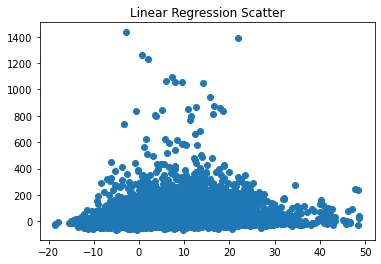

In [496]:
plt.title('Linear Regression Scatter')
plt.scatter(lin_pred,y_test)
plt.show()

### **Linear regression with PCA**

In [497]:
# Linear Regression on PCA Components, grid search again with same hyperparams as before for lin reg
grid_lin_pca = GridSearchCV(LinearRegression(), lin_params, cv=5, verbose=1, n_jobs=-1)
grid_lin_pca.fit(X_pca_train, y_pca_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=LinearRegression(), n_jobs=-1,
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'normalize': [True, False]},
             verbose=1)

### *Summary of Findings for Linear Regression PCA Model and Hyper Tuning* 


In [498]:
pca_lin_reg = grid_lin_pca.best_estimator_
pca_lin_reg_score = cross_val_score(pca_lin_reg, X_pca_train, y_pca_train, cv=5)
y_pca_linreg = pca_lin_reg.predict(X_pca_test)
########################################################################################################
df_lin_pca = pd.DataFrame({'Predicted':y_pca_linreg[:,0],'Actual':np.array(y_pca_test.iloc[:,0])})
df_lin_pca['residuals'] = df_lr['Actual']-df_lr['Predicted']
########################################################################################################
print("The variance between the actual arrival delays is {} minutes".format(df_lin_pca.loc[:,"Actual"].var()))
print('Cross Validation Score: ', round(pca_lin_reg_score.mean() * 100, 2).astype(str) + '%')
print("Training R2 / Variance: ", round(grid_lin_pca.best_score_,2))
print('RMSE Score \t{:.2f}'.format(metrics.mean_squared_error(y_pca_test, y_pca_linreg)))
########################################################################################################
df_lin_pca

The variance between the actual arrival delays is 2396.920476584138 minutes
Cross Validation Score:  1.91%
Training R2 / Variance:  0.02
RMSE Score 	2341.59


,Predicted,Actual,residuals
0,7.221669,-1.0,-24.619254
1,8.412978,-32.0,45.876855
2,0.374904,0.0,10.541266
3,0.072767,-15.0,13.194499
4,14.186173,-6.0,-7.610934
...,...,...,...
39306,5.863958,-23.0,1.563823
39307,6.483438,-36.0,-13.032613
39308,-4.547053,-1.0,-25.100933
39309,5.589563,-7.0,29.269301


### *Linear regression model using principal components scatter plot (predicted against test)*

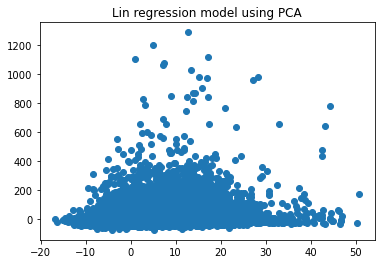

In [499]:
plt.title('Lin regression model using PCA')
plt.scatter(y_pca_linreg,y_pca_test)
plt.show()

## **Ridge Regression**

In [500]:
#Trying to optimize a ridge refression model, applying grid search to find optimal hyperparameter selection, only performing 20 fits
param_grid = {'alpha': [0.001,0.01,0.1,0.5]}
grid = GridSearchCV(estimator = Ridge(normalize = True), param_grid = param_grid, n_jobs=-1, verbose = 1)

In [501]:
grid.fit(X_train,y_train)
grid.best_params_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


{'alpha': 0.01}

In [502]:
#found out optimal hyperparameters through grid search, now creating ridge regression model with set parameters 
reg = Ridge(alpha = grid.best_params_['alpha'], normalize = True)

In [503]:
reg.fit(X_train,y_train)

Ridge(alpha=0.01, normalize=True)

### *Ridge regression Metrics*

In [504]:
reg_pred = reg.predict(X_test)

In [505]:
print("Ridge regression mean squared error value (unnormalized): {}".format(metrics.mean_squared_error(y_test,reg_pred)))
print("Ridge regression r^2 value: {}".format(metrics.r2_score(y_test,reg_pred)))

Ridge regression mean squared error value (unnormalized): 2216.065733526631
Ridge regression r^2 value: 0.021623133364046088


### *Linear regression model scatter plot (predicted against test)*

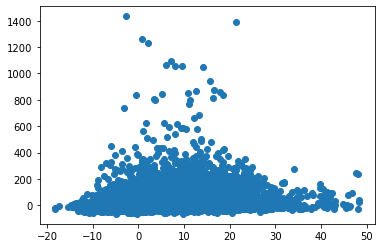

In [506]:
plt.scatter(reg_pred,y_test)
plt.show()

### *Summary of Findings for Ridge Regression Model*

In [507]:
df_rr = pd.DataFrame({'Predicted':reg_pred[:,0],'Actual':np.array(y_test.iloc[:,0])})
df_rr['residuals'] = df_rr['Actual']-df_lr['Predicted']
########################################################################################################
print("The variance between the actual values is {} minutes".format(df_rr.loc[:,"Actual"].var()))
print("The mean residual is: {}".format(np.mean(df_rr)[2]))
print('R2 Score \t{:.2f}'.format(metrics.r2_score(y_test, reg_pred)))
print('RMSE Score \t{:.2f}'.format(metrics.mean_squared_error(y_test,reg_pred)))
########################################################################################################
df_rr

The variance between the actual values is 2265.100681748665 minutes
The mean residual is: -0.7142347601030572
R2 Score 	0.02
RMSE Score 	2216.07


,Predicted,Actual,residuals
0,6.599767,-18.0,-24.619254
1,10.996548,57.0,45.876855
2,4.546311,15.0,10.541266
3,6.822185,20.0,13.194499
4,-0.274320,-8.0,-7.610934
...,...,...,...
39306,8.297256,10.0,1.563823
39307,-4.072609,-17.0,-13.032613
39308,4.246812,-21.0,-25.100933
39309,9.608666,39.0,29.269301


## **Logistic Regression**

In [ ]:
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_log = GridSearchCV(LogisticRegression(), log_params, cv=3)
grid_log.fit(X_train, y_train)
logreg = grid_log.best_estimator_
logreg_score = cross_val_score(logreg, X_train, y_train, cv=3, verbose=1, njobs=-1)

## **XGBoost**

In [115]:
xgbr = XGBRegressor(objective='reg:squarederror', n_estimators=1000, colsample_bytree = 1.0,learning_rate = 0.001,max_depth = 5,alpha =20)
xgbr.fit(X_train,y_train)

XGBRegressor(alpha=20, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.001, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=20, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

### *XGBoost metrics*

In [116]:
score = xgbr.score(X_train, y_train)  
print("Training score: ", score)

Training score:  -0.009043723966834616


In [117]:
scores = cross_val_score(xgbr, X_train, y_train,cv=3)
print("Mean cross-validation score: %.2f" % scores.mean())

Mean cross-validation score: -0.01


In [118]:
xgbr_pred = xgbr.predict(X_test)

In [119]:
metrics.r2_score(y_test,xgbr_pred)

-0.022129816061734697

## **Random Forest**

In [ ]:
%%time
tree_params = {"n_estimators": [100, 250, 500, 750, 1000],
               'max_depth': [int(x) for x in np.linspace(1, 32, num = 5)]}
grid_ptree = GridSearchCV(RandomForestRegressor(random_state=1), tree_params, cv=3, verbose=1, n_jobs=-1)
grid_ptree.fit(Xpca_train, ypca_train)
pforest = grid_ptree.best_estimator_
pforest.get_params

In [508]:
regr = RandomForestRegressor(n_estimators=40, max_depth=6, random_state=0)
regr.fit(X_train,y_train)

RandomForestRegressor(max_depth=6, n_estimators=40, random_state=0)

In [509]:
forest_pred=regr.predict(X_test)

### *random forest metrics and hyper tuning*

In [510]:
print("Randorm Forest mean squared error value (unnormalized): {}".format(mean_absolute_error(y_test, forest_pred)))
print("Random Forest r^2 value: {}".format(r2_score(y_test, forest_pred)))

Randorm Forest mean squared error value (unnormalized): 23.828716386415255
Random Forest r^2 value: 0.02116609152026716


In [511]:
%%time
tree_params = {"n_estimators": [100, 250, 500, 750, 1000],
               'max_depth': [int(x) for x in np.linspace(1, 32, num = 5)]}
grid_ptree = GridSearchCV(RandomForestRegressor(random_state=1), tree_params, cv=3, verbose=1, n_jobs=-1)
grid_ptree.fit(X_pca_train, y_pca_train)
pforest = grid_ptree.best_estimator_
pforest.get_params

Fitting 3 folds for each of 25 candidates, totalling 75 fits


KeyboardInterrupt: 

## **SVM / Naive Bayes (didn't work well with our mode/ took wayyyyyyyy to long)**

In [ ]:
# svr_params = {'kernel': ['linear','rbf','poly'],
#               'C': [1, 5, 10],
#               'gamma': [0.0000001, 0.00001, 0.001, 0.1, 1],
#               'epsilon': [0.1, 0.2, 0.3, 0.5 ]
#              }
# grid_svr = GridSearchCV(SVR(), svr_params, cv=3, verbose=1, n_jobs=-1)
# grid_svr.fit(X_train_samp, y_train_samp)
# svr = grid_svr.best_estimator_
# svr.get_params 
#to long to run (Fitting 3 folds for each of 180 candidates, totalling 540 fits)

## **Evaluation**

You have data from 2018 and 2019 to develop models. Use different evaluation metrics for each problem and compare the performance of different models.

You are required to predict delays on **out of sample** data from **first 7 days (1st-7th) of January 2020** and to share the file with LighthouseLabs. Sample submission can be found in the file **_sample_submission.csv_**

In [445]:
data_submission = pd.read_csv('/Users/arjunduggal/Desktop/lighthouse-data-notes/Midterm_1/Data/flighttest.csv')

## **Filtering data based on time frame of reference (jan1 to jan7)**

In [446]:
data_submission['fl_date'] = pd.to_datetime(sub_sample['fl_date'], errors='coerce')

In [447]:
start_date = '2020-01-01'
end_date = '2020-01-07'
dates = (data_submission['fl_date'] >= start_date) & (data_submission['fl_date']<=end_date)
data_submission = data_submission.loc[dates]

In [448]:
data_submission

,Unnamed: 0,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,...,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,crs_arr_time,dup,crs_elapsed_time,flights,distance
0,0,2020-01-01,WN,WN,WN,5888,WN,N951WN,5888,13891,...,"Ontario, CA",14771,SFO,"San Francisco, CA",1810,1945,N,95,1,363
1,1,2020-01-01,WN,WN,WN,6276,WN,N467WN,6276,13891,...,"Ontario, CA",14771,SFO,"San Francisco, CA",1150,1320,N,90,1,363
2,2,2020-01-01,WN,WN,WN,4598,WN,N7885A,4598,13891,...,"Ontario, CA",14831,SJC,"San Jose, CA",2020,2130,N,70,1,333
3,3,2020-01-01,WN,WN,WN,4761,WN,N551WN,4761,13891,...,"Ontario, CA",14831,SJC,"San Jose, CA",1340,1455,N,75,1,333
4,4,2020-01-01,WN,WN,WN,5162,WN,N968WN,5162,13891,...,"Ontario, CA",14831,SJC,"San Jose, CA",915,1035,N,80,1,333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150618,150618,2020-01-07,DL,DL_CODESHARE,DL,4813,9E,N605LR,4813,11433,...,"Detroit, MI",12478,JFK,"New York, NY",1755,1952,N,117,1,509
150619,150619,2020-01-07,DL,DL_CODESHARE,DL,4814,9E,N919XJ,4814,11996,...,"Greer, SC",12953,LGA,"New York, NY",600,759,N,119,1,610
150620,150620,2020-01-07,DL,DL_CODESHARE,DL,4815,9E,N936XJ,4815,10397,...,"Atlanta, GA",15919,XNA,"Fayetteville, AR",1715,1816,N,121,1,589
150621,150621,2020-01-07,DL,DL_CODESHARE,DL,4815,9E,N936XJ,4815,15919,...,"Fayetteville, AR",10397,ATL,"Atlanta, GA",1851,2145,N,114,1,589


## **Applying all created features to our df for testing purposes**

In [449]:
final_df = data_submission[['fl_date','mkt_carrier','mkt_unique_carrier','mkt_carrier_fl_num','op_unique_carrier','crs_elapsed_time',
                            'op_carrier_fl_num','origin_airport_id','origin','origin_city_name', 'dest_airport_id',
                           'dest', 'dest_city_name', 'crs_dep_time','crs_arr_time','distance','flights']]

In [450]:
final_df = final_df.loc[dates]

In [451]:
month_to_season = {1: 1, 2: 1, 3: 2, 4: 2, 5: 2, 6: 3, 7: 3, 8: 3, 9: 4, 10: 4, 11: 4, 12: 1}
final_df['fl_date'] = pd.to_datetime(final_df['fl_date'], errors='coerce')
final_df['month'] = final_df['fl_date'].dt.month
final_df['day_of_week'] = final_df['fl_date'].dt.dayofweek
final_df['day_of_month'] = final_df['fl_date'].dt.day
final_df['year'] = final_df['fl_date'].dt.year
final_df['season'] = final_df['month'].map(month_to_season)
#model_df.drop(columns=['fl_date'],inplace=True)

In [452]:
time_cat(final_df,'crs_elapsed_time')

In [453]:
final_df.time_cat.value_counts()

0    116196
1     31689
2      2738
Name: time_cat, dtype: int64

In [454]:
final_df = pd.merge(final_df,additional_info_df, how = 'left', left_on=['mkt_carrier','month'], right_on=['carrier','month']).drop(columns='carrier')
final_df['pass_per_dep'] = final_df['passengers']/final_df['departures_performed']
final_df['seats_filled'] = final_df['passengers']/final_df['seats']

In [455]:
final_df=final_df.drop(columns=['departures_performed','seats','passengers'])

In [456]:
avg_plane_velo(final_df,'distance','crs_elapsed_time')

In [457]:
final_df['dep_time_milatary'] = final_df['crs_dep_time'].apply(time_row)

In [458]:
final_df['arr_time_milatary'] = final_df['crs_arr_time'].apply(time_row)

In [459]:
time_day(final_df,'dep_time_milatary','dep_time_haul')

150623


,dep_time_haul
0,3
1,1
2,3
3,2
4,1
...,...
150618,2
150619,1
150620,2
150621,3


In [460]:
time_day(final_df,'arr_time_milatary','arr_time_haul')

150623


,arr_time_haul
0,3
1,2
2,3
3,2
4,1
...,...
150618,3
150619,1
150620,3
150621,3


In [461]:
final_df['origin_state'] = final_df['origin_city_name'].str[-2:]
final_df['dest_state']= final_df['dest_city_name'].str[-2:]

In [462]:
final_df['origin_airport_volume'] = final_df.groupby(['origin_airport_id'])['flights'].transform(np.sum) 

In [463]:
final_df['dest_aiport_volume'] = final_df.groupby(['dest_airport_id'])['flights'].transform(np.sum)

In [464]:
final_df['carrier_origin_apt_vol'] = final_df.groupby(['origin_airport_id','op_unique_carrier'])['flights'].transform(np.sum)
final_df['carrier_dest_apt_vol'] = final_df.groupby(['dest_airport_id','op_unique_carrier'])['flights'].transform(np.sum)

In [465]:
final_df['carrier_origin_apt_pct'] = final_df['carrier_origin_apt_vol'] / final_df['origin_airport_volume'] * 100
final_df['carrier_dest_apt_pct'] = final_df['carrier_dest_apt_vol'] / final_df['dest_aiport_volume'] * 100

In [466]:
final_df['mean_carrier_arr_delay'] = temp.groupby(['op_unique_carrier','month'])['arr_delay'].transform(np.mean)
final_df['mean_carrier_dep_delay'] = temp.groupby(['op_unique_carrier','month'])['dep_delay'].transform(np.mean)

In [468]:
for i in ['op_unique_carrier','origin','dest','origin_state','dest_state']:
    final_df[[i]] = temp[[i]].astype('category')

In [469]:
final_df['op_unique_carrier'] = final_df.op_unique_carrier.cat.codes
final_df['origin'] = final_df.origin.cat.codes
final_df['dest'] = final_df.dest.cat.codes
final_df['origin_state'] = final_df.origin_state.cat.codes
final_df['dest_state'] = final_df.dest_state.cat.codes

## **Dropping Unwanted Colums**

In [470]:
final_df.drop(columns=['crs_dep_time','crs_arr_time','origin_city_name','dest_city_name','dep_time_milatary','arr_time_milatary'
                       ,'fl_date','mkt_carrier','crs_elapsed_time','origin_airport_id','dest_airport_id'],inplace=True,axis=1)

In [471]:
final_df.drop(columns=['mkt_unique_carrier','mkt_carrier_fl_num'],inplace=True)

In [274]:
model_df

,op_unique_carrier,origin,dest,flights,distance,delay_occured,month,day_of_week,day_of_month,year,...,origin_state,dest_state,origin_airport_volume,dest_aiport_volume,carrier_origin_apt_vol,carrier_dest_apt_vol,carrier_origin_apt_pct,carrier_dest_apt_pct,mean_carrier_arr_delay,mean_carrier_dep_delay
0,2,95,306,1.0,1017.0,1,3,0,18,2019,...,44,8,7097.0,873.0,3647.0,111.0,51.387910,12.714777,3.774210,9.466356
1,2,307,74,1.0,2077.0,1,6,2,19,2019,...,4,26,2412.0,6209.0,225.0,2472.0,9.328358,39.813174,12.272488,16.439037
2,22,94,59,1.0,1491.0,0,10,1,23,2018,...,5,19,6797.0,2602.0,1611.0,94.0,23.701633,3.612606,2.155639,5.813953
3,24,193,247,1.0,407.0,1,9,4,7,2018,...,32,4,4142.0,1337.0,1809.0,1036.0,43.674553,77.486911,-1.644198,5.766234
4,19,195,308,1.0,109.0,0,11,6,4,2018,...,4,4,6162.0,2435.0,817.0,220.0,13.258682,9.034908,2.425584,7.480416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196550,24,326,25,1.0,1476.0,0,7,1,30,2019,...,4,44,1639.0,1618.0,821.0,606.0,50.091519,37.453646,6.291638,13.244753
196551,12,274,145,1.0,482.0,1,4,2,10,2019,...,8,40,194.0,394.0,194.0,7.0,100.000000,1.776650,5.829493,7.206422
196552,4,152,94,1.0,141.0,0,3,3,21,2019,...,5,5,35.0,6825.0,10.0,553.0,28.571429,8.102564,9.159722,12.179310
196553,22,256,334,1.0,1726.0,1,11,0,19,2018,...,13,4,9654.0,1100.0,1931.0,148.0,20.002072,13.454545,4.774797,8.357895


In [472]:
for i in final_df.columns:
    if not i in (X.columns):
        final_df.drop(columns=[i],inplace=True)

In [513]:
X

,distance,season,time_cat,pass_per_dep,avg_plane_velocity,dep_time_haul,arr_time_haul,dest_state,origin_airport_volume,dest_aiport_volume,carrier_origin_apt_vol,carrier_dest_apt_vol,carrier_origin_apt_pct,carrier_dest_apt_pct,mean_carrier_arr_delay
0,1017.0,2.0,0.0,137.120517,415.102041,2.0,3.0,8.0,7097.0,873.0,3647.0,111.0,51.387910,12.714777,3.774210
1,2077.0,3.0,1.0,140.883487,426.780822,1.0,3.0,26.0,2412.0,6209.0,225.0,2472.0,9.328358,39.813174,12.272488
2,1491.0,4.0,1.0,142.235989,442.871287,2.0,0.0,19.0,6797.0,2602.0,1611.0,94.0,23.701633,3.612606,2.155639
3,407.0,4.0,0.0,117.019843,271.333333,2.0,3.0,4.0,4142.0,1337.0,1809.0,1036.0,43.674553,77.486911,-1.644198
4,109.0,4.0,0.0,143.766544,118.909091,1.0,1.0,4.0,6162.0,2435.0,817.0,220.0,13.258682,9.034908,2.425584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196550,1476.0,3.0,1.0,123.820258,421.714286,1.0,2.0,44.0,1639.0,1618.0,821.0,606.0,50.091519,37.453646,6.291638
196551,482.0,2.0,0.0,141.505765,324.943820,1.0,1.0,40.0,194.0,394.0,194.0,7.0,100.000000,1.776650,5.829493
196552,141.0,2.0,0.0,143.017015,126.268657,1.0,1.0,5.0,35.0,6825.0,10.0,553.0,28.571429,8.102564,9.159722
196553,1726.0,4.0,1.0,143.766544,390.792453,3.0,3.0,4.0,9654.0,1100.0,1931.0,148.0,20.002072,13.454545,4.774797


In [514]:
final_df

,distance,season,time_cat,pass_per_dep,avg_plane_velocity,dep_time_haul,arr_time_haul,dest_state,origin_airport_volume,dest_aiport_volume,carrier_origin_apt_vol,carrier_dest_apt_vol,carrier_origin_apt_pct,carrier_dest_apt_pct,mean_carrier_arr_delay
0,363,1,0,109.434615,229.263158,3,3,8,465,3278,242,266,52.043011,8.114704,3.774210
1,363,1,0,109.434615,242.000000,1,2,26,465,3278,242,266,52.043011,8.114704,12.272488
2,333,1,0,109.434615,285.428571,3,3,19,465,1304,242,684,52.043011,52.453988,2.155639
3,333,1,0,109.434615,266.400000,2,2,4,465,1304,242,684,52.043011,52.453988,-1.644198
4,333,1,0,109.434615,249.750000,1,1,4,465,1304,242,684,52.043011,52.453988,2.425584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150618,509,1,0,130.291170,261.025641,2,3,26,3005,2306,397,301,13.211314,13.052905,3.774210
150619,610,1,0,130.291170,307.563025,1,1,44,333,2771,28,356,8.408408,12.847348,2.100383
150620,589,1,0,130.291170,292.066116,2,3,3,6975,276,966,41,13.849462,14.855072,5.766049
150621,589,1,0,130.291170,310.000000,3,3,35,275,6967,42,973,15.272727,13.965839,1.341975


## **Prediction with actual Test**

In [481]:
#creating and fitting the linear regression model with our test and trained data from prior
lr2 = LinearRegression()
lr2.fit(X,y)
lin_pred_good = lr2.predict(final_df)

In [482]:
lin_pred_good

array([[10.54620917],
       [ 8.91937612],
       [ 8.93868992],
       ...,
       [ 8.10995814],
       [10.72129778],
       [-6.7232431 ]])

In [485]:
data_submission = data_submission[['fl_date','mkt_carrier','mkt_carrier_fl_num','origin','dest']]
data_submission['predicted_delay'] = lin_pred_good

In [487]:
data_submission.to_csv('submission.csv')

In [512]:
data_submission

,fl_date,mkt_carrier,mkt_carrier_fl_num,origin,dest,predicted_delay
0,2020-01-01,WN,5888,ONT,SFO,10.546209
1,2020-01-01,WN,6276,ONT,SFO,8.919376
2,2020-01-01,WN,4598,ONT,SJC,8.938690
3,2020-01-01,WN,4761,ONT,SJC,-1.794025
4,2020-01-01,WN,5162,ONT,SJC,-4.279366
...,...,...,...,...,...,...
150618,2020-01-07,DL,4813,DTW,JFK,6.175852
150619,2020-01-07,DL,4814,GSP,LGA,-3.432463
150620,2020-01-07,DL,4815,ATL,XNA,8.109958
150621,2020-01-07,DL,4815,XNA,ATL,10.721298
